# Controller Tuning Rules in Frequency Domain

Demonstrate the use of a Bode plot for controller tuning. The notebook uses the [Python Control Systems Library](https://github.com/python-control/python-control).  

## Closed-Loop Transfer Functions

### Process Transfer Functions

The process output $y$ is modeled as the output of a linear system described by the transfer function 

$$y = G_p(s)G_v(s) u + G_d(s) d$$

where $G_p(s)$ is the process response to a manipulated variable, $G_v(s)$ is the transfer function of the actuator dynamics, and $G_d(s)$ is process response to a disturbance. The measured process output is given by

$$y_m = G_m(s) y$$

where $G_m(s)$ is the sensor transfer function. We assume the sensor has unit gain, i.e., $G_m(0) = 1$

### Control Transfer Functions

The controller generates a command $u$ in response to the reference input $r$ and measured process output $y_m$. This is modeled as

$$u = G_r(s)r - G_y(s)y_m$$

where $G_r(s)$ and $G_y(s)$ are the controller transfer functions. Textbook simulations often set $G_r(s) = G_y(s)$ for PID control.  In practice, however, it is generally desireable to avoid excessive action in response to setpoint changes, so generally $G_r \neq G_y$.

Below we employ a parallel implementation of PID control for output feedback where

$$G_y(s) = K_p\left[ 1 + \frac{1}{\tau_Is} + \frac{\tau_D s}{\alpha\tau_Ds + 1}\right]$$

where parameter $\alpha$ limits excessive derivative action. Typical values of $\alpha$ are in the range 0.2 to 0.1.

For the reference signal, $G_r(s)$ has the same general form but with additional parameters $\beta$ and $\gamma$

$$G_r(s) = K_p\left[ \beta + \frac{1}{\tau_Is} + \gamma\frac{\tau_D s}{\alpha\tau_Ds + 1}\right]$$

Commonly $\gamma = 0$ to avoid derivative action on the reference signal. Parameter $\beta$ is typically set to a value $0\leq\beta\leq 1$ that balances prompt response to a setpoint against undue 'kicks' caused by sudden changes in setpoint.

### Closed Loop Transfer Functions

The overall response of the closed-loop system is characterized by a set of four transfer functions relating the reference and disturbance inputs to the process output $y$ and the control command $u$.

$$\begin{align*}
y & = H_{yr}(s)r + H_{yd}(s)d \\
u & = H_{ur}(s)r + H_{ud}(s)d
\end{align*}
$$

The closed-loop transfer functions are given explicitly as 

$$H_{yr} = \frac{G_pG_vG_r}{1 + G_pG_vG_yG_m}$$

$$H_{yd} = \frac{G_d}{1 + G_pG_vG_yG_m}$$

$$H_{ur} = \frac{G_r}{1 + G_yG_mG_pG_v}$$

$$H_{ud} = -\frac{G_yG_mG_d}{1 + G_yG_mG_pG_v}$$

where the argument $s$ has been suppressed for brevity.


## Example


We'll assume a process transfer function with time delay

$$G_p(s) = \frac{0.2}{s^2 + 1.5 s + 1}$$

and a disturbance response

$$G_d(s) = \frac{1}{s + 1}$$

and a measurement transfer function

$$G_m(s) = e^{-s}$$

We'll assume the dynamics of the actuator are negligible such that $G_v(s) = 1$. 

The Python Control Systems Library does not provide a specific representation for time delay. It does, however, provide a function `pade` for creating Pade approximations to time delay systems.

### Entering Process Transfer Functions

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from control.matlab import *

Gp = tf([0.2],[1, 1.5, 1])
print("Gp = ", Gp)

Gd = tf([1],[1,1])
print("Gd = ", Gd)

Gv = tf([1],[1])
print("Gv = ", Gv)

(num,den) = pade(1.0,3)
Gm = tf(num,den)
print("Gm = ", Gm)

Gp =  
      0.2
---------------
s^2 + 1.5 s + 1

Gd =  
  1
-----
s + 1

Gv =  
1
-
1

Gm =  
-s^3 + 12 s^2 - 60 s + 120
--------------------------
s^3 + 12 s^2 + 60 s + 120



### Finding Cross-Over Frequency and Gain at Cross-Over

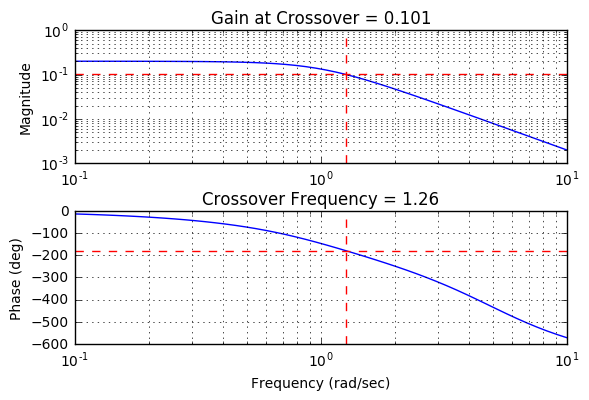

In [2]:
w = np.logspace(-1,1)
mag,phase,omega = bode(Gp*Gm*Gv,w)
plt.tight_layout()

# find the cross-over frequency and gain at cross-over
wc = np.interp(-180.0,np.flipud(phase),np.flipud(omega))
gc = np.interp(wc,omega,mag)

# get the subplots axes
ax1,ax2 = plt.gcf().axes

# add features to the magnitude plot
plt.sca(ax1)
plt.plot([omega[0],omega[-1]],[gc,gc],'r--')
[gmin,gmax] = plt.ylim()
plt.plot([wc,wc],[gmin,gmax],'r--')
plt.title("Gain at Crossover = {0:.3g}".format(gc))

# add features to the phase plot
plt.sca(ax2)
plt.plot([omega[0],omega[-1]],[-180,-180],'r--')
[pmin,pmax] = plt.ylim()
plt.plot([wc,wc],[pmin,pmax],'r--')
plt.title("Crossover Frequency = {0:.3g}".format(wc))

### Computing Ultimate Gain and Period

The conventional tuning rules for process control are written in terms of an ultimate gain $K_{cu}$ and ultimate period $P_u$. These are the values obtained by an experiment or calculation where the gain of a proportional only controller is increased until a steady closed-loop oscillation is first observed. The corresponding proportional gain is $K_{cu}$, and the period of oscillation is $P_u$.

These values may be computed from a Bode plot. The ultimate period corresponds to

$$P_u = \frac{2\pi}{\omega_c}$$

where $\omega_c$ is the cross-over frequency. The ultimate gain is then

$$K_{cu} = \frac{1}{G_p(\omega_c)}$$

where $G_p(\omega_c)$ is the open-loop process gain at the cross-over frequency.

In [3]:
Kcu = 1.0/gc
Pu = 2.0*np.pi/wc

## Ziegler-Nichols Tuning Rules

| Control | $K_p$       | $\tau_I$          | $\tau_D$        |
| :-----: | :---------: | :---------------: | :-------------: |
| P       | $0.5K_{cu}$ | $-$               | $-$             |
| PI      | $0.45K_{cu}$| $\frac{P_u}{1.2}$ | $-$             |
| PID     | $0.6K_{cu}$ | $\frac{P_u}{2}$   | $\frac{P_u}{8}$ |

In [20]:
Kp = 0.6*Kcu
tauI = Pu/2.0
tauD = Pu/8.0

print("Ziegler-Nichols PID Tuning")
print("Kp   = {0:0.3g}".format(Kp))
print("tauI = {0:0.3g}".format(tauI))
print("tauD = {0:0.3g}".format(tauD))

Ziegler-Nichols PID Tuning
Kp   = 5.97
tauI = 2.48
tauD = 0.621


### Interactive Tuning of a PID Controller

The following cell is initiated with the Ziegler-Nichols tuning for PID control. Interactive sliders can be adjusted to tune the controller for acceptable response.

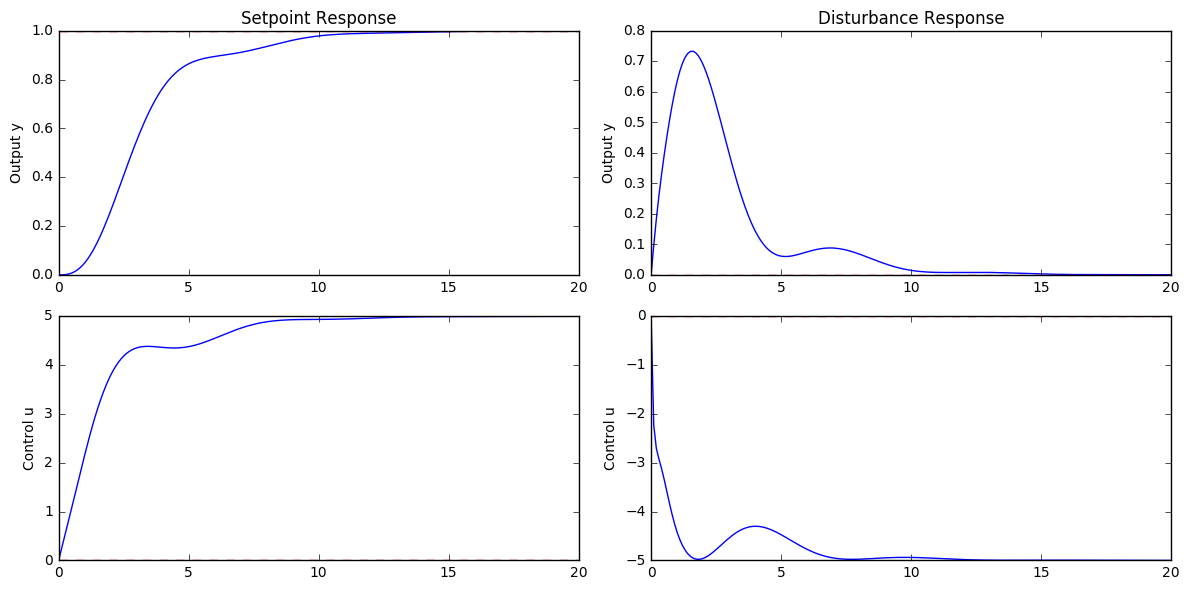

In [29]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def f(alpha=0.1,beta=0.5,gamma=0.0,Kp=0.6*Kcu,tauI=Pu/2.0,tauD=Pu/8.0):
    
    # parallel implementation of PID control
    P = Kp * tf([1.0],[1.0])
    I = (Kp/tauI) * tf([1.0],[1.0,0.0])
    D = Kp*tauD * tf([1.0,0.0],[alpha*tauD,1.0])

    # controller transfer functions
    Gr = beta*P + I + gamma*D
    Gy = P + I + D

    t = np.linspace(0,20,200)
    plt.figure(figsize=(12,6))

    yr,t = step(Gp*Gv*Gr/(1+Gp*Gv*Gy*Gm),t)
    plt.subplot(2,2,1)
    plt.plot(t,yr)
    plt.plot(plt.xlim(),[1.0,1.0],'r--')
    plt.title('Setpoint Response')
    plt.ylabel('Output y')

    yd,t = step(Gd/(1+Gp*Gv*Gy*Gm),t)
    plt.subplot(2,2,2)
    plt.plot(t,yd)
    plt.plot(plt.xlim(),[0.0,0.0],'r--')
    plt.title('Disturbance Response')
    plt.ylabel('Output y')

    ur,t = step(Gr/(1+Gy*Gm*Gp*Gv),t)
    plt.subplot(2,2,3)
    plt.plot(t,ur)
    plt.plot(plt.xlim(),[0.0,0.0],'r--')
    plt.ylabel('Control u')

    ud,t = step(-Gy*Gd/(1+Gy*Gm*Gp*Gv),t)
    plt.subplot(2,2,4)
    plt.plot(t,ud)
    plt.plot(plt.xlim(),[0.0,0.0],'r--')
    plt.ylabel('Control u')

    plt.tight_layout()
    
interact(f, 
         alpha=fixed(0.1), 
         Kp = (0.01*Kcu,Kcu),
         tauI = (Pu/20.0,Pu),
         tauD = (0.0,Pu),
         continuous_update=False)